In [ ]:
# default_exp core

# core

> API details. See docs for now.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
import os, inspect, datetime, logging, numpy as np, pandas as pd, scipy as sp
from scipy.spatial.distance import pdist, cdist
import seaborn as sns, matplotlib.pyplot as plt
from typing import Union, Optional, Tuple, Literal, TypeVar 
from collections.abc import Callable
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import numpy.matlib


In [ ]:
#export
__file = inspect.getfile(lambda: None)

ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(__file), '.'))
LOG_FILE = os.path.join(ROOT_DIR, 'log.txt')

if not os.path.isdir(ROOT_DIR):
    os.makedirs(ROOT_DIR)

basename = os.path.basename(LOG_FILE)
logger = logging.getLogger(LOG_FILE)

logging.basicConfig(
    filename=LOG_FILE, 
    level=logging.INFO,#.DEBUG,
    format='%(asctime)s\t%(levelname)s:%(message)s',
    datefmt='%d/%m/%Y %I:%M:%S %p',
    filemode='w'
)

In [ ]:
#exports
VALID_SIGMAS = 'minmax median std knn'.split()
SigmaType = TypeVar('SigmaType', Literal["minimax", "median", "std", "knn"], Callable, float, int)
def validate_sigma(
    sigma:SigmaType, 
    logger:Optional[logging.Logger]=None
) -> None:
    '''
    Notes:
    ---------
        - `sigma` (Gaussian kernel bandwidth)
            + `"std"`: standard deviation of the distances
            + `"knn"`: adaptive bandwidth, eg kth neighbor distance
            + `"minmax"`: min-max on the distance matrix
            + `"median"`: the median of the distances
            + `callable`: a function, f, such that f(d) returns a scalar or N-length vector
                where d is an NxN distance matrix
            + `scalar`: pre-computed bandwidth

    Arguments:
    ----------
        sigma (str | Callable): The type of sigma function to use or a user defined function. 
            Valid `sigma` values include `"minmax"`, `"median"`, `"std"`, `"knn"`. Defaults to 
            `"knn"`.
            
        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        None
    '''
    is_known = sigma in VALID_SIGMAS or callable(sigma) or isinstance(sigma, (int, float))
    message = (
        f'sigma ({sigma}) is {"" if is_known else "not "}known or callable.\n'
        f'known sigmas include {VALID_SIGMAS}'
    )
    if logger: logger.info(message)
    if not is_known:
        raise ValueError(message)

In [ ]:
#exports
def gauss_kernel(
    data1:np.ndarray,
    data2:np.ndarray,
    sigma:SigmaType='knn',
    k:int=5,
    a:int=2,
    fac:int=1,
    logger:Optional[logging.Logger]=None
) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/gauss_kernel.m

        - compute degree and sparsity estimates of data   https://arxiv.org/abs/1802.04927

        - `sigma` (Gaussian kernel bandwidth)
            + `"std"`: standard deviation of the distances
            + `"knn"`: adaptive bandwidth, eg kth neighbor distance
            + `"minmax"`: min-max on the distance matrix
            + `"median"`: the median of the distances
            + `callable`: a function, f, such that f(d) returns a scalar or N-length vector
                where d is an NxN distance matrix
            + `scalar`: pre-computed bandwidth
        
        - `a` (Alpha kernel decay)
            + `a=2` is Gaussian kernel

    Arguments:
    ----------
        data1 (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.

        data2 (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.

        sigma (str | Callable): The type of sigma function to use or a user defined function. 
            Valid `sigma` values include `"minmax"`, `"median"`, `"std"`, `"knn"`. Defaults to 
            `"knn"`.
        
        k (int): K-nearest neighbor distance to use if `sigma="knn"`. Defaults to `5`.

        a (int): Alpha-kernel decay parameter. Defaults to `1`. Note `a=2` is the Gaussian
            kernel.

        fac (int): Rescale kernel bandwidth. Defaults to `1`.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        K (np.ndarray): kernel over data1, data2

        sigma (np.ndarray): Nx1 (adaptive) or scalar (constant) estiamted kernel bandwidth
    '''
    validate_sigma(sigma, logger)
    
    D = cdist(data1, data2)
    N = D.shape[1]
    if sigma == 'minmax':
        min_dev = np.min(D + np.eye(D.shape[0]) * (10 ** 15))
        eps_val = np.max(min_dev)
        sigma = 2 * (eps_val ** 2)        

    elif sigma == 'median':
        sigma = np.median(np.median(D))

    elif sigma == 'std':
        # sigma = std(mean(D))
        sigma = np.std(np.mean(D, axis=0))

    elif sigma == 'knn':
        knn_dist = np.sort(D)
        # sigma = knn_dist(k+1,:);
        sigma = knn_dist[k-1, :]

    elif isinstance(sigma, (int, float)):
        sigma = sigma

    elif callable(sigma):
        sigma = sigma(D)

    else:
        pass
    sigma = sigma * fac

    # K = bsxfun(@rdivide, D, sigma);
    K = np.apply_along_axis(np.divide, 0, D, sigma)
    K = np.exp(-np.power(K, a))
    
    K[np.isnan(K)] = 0
    K[np.where(K < 1e-3)] = 0
    
    if K.shape[0] == K.shape[1]:
        K = (K + K.T) / 2
    
    return K, sigma

In [ ]:
data1 = np.arange(25).reshape(5, 5)
data2 = np.zeros((5, 5))
data2[0, 1] = 1
# data2=data1

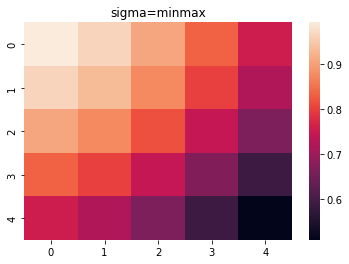

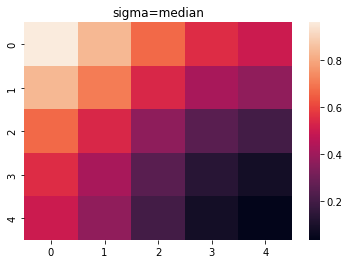

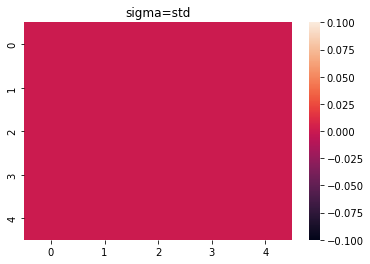

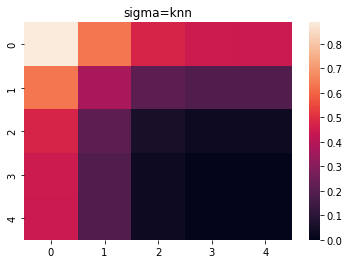

In [ ]:
for sigma in VALID_SIGMAS:
    K, sig = gauss_kernel(data1, data2, k=2, sigma=sigma)
    fig = plt.figure()
    ax = sns.heatmap(K)
    ax.set_title(f'sigma={sigma}')
    ax

In [ ]:
#exports
def degrees(
    data:np.ndarray,
    sigma:SigmaType='std',
    k:int=5,
    a:int=2,
    fac:int=1,
    logger:Optional[logging.Logger]=None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/degrees.m

        - compute degree and sparsity estimates of data   https://arxiv.org/abs/1802.04927

        - `sigma` (Gaussian kernel bandwidth)
            + `"std"`: standard deviation of the distances
            + `"knn"`: adaptive bandwidth, eg kth neighbor distance
            + `"minmax"`: min-max on the distance matrix
            + `"median"`: the median of the distances
            + `callable`: a function, f, such that f(d) returns a scalar or N-length vector
                where d is an NxN distance matrix
            + `scalar`: pre-computed bandwidth
        
        - `a` (Alpha kernel decay)
            + `a=2` is Gaussian kernel

    Arguments:
    ----------
        data (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.


        sigma (str | Callable): The type of sigma function to use or a user defined function. 
            Valid `sigma` values include `"minmax"`, `"median"`, `"std"`, `"knn"`. Defaults to 
            `"std"`.
        
        k (int): K-nearest neighbor distance to use if `sigma="knn"`. Defaults to `5`.

        a (int): Alpha-kernel decay parameter. Defaults to `1`. Note `a=2` is the Gaussian
            kernel.

        fac (int): Rescale kernel bandwidth. Defaults to `1`.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        d_hat (np.ndarray): N x 1 vector of the degree at each point in data of size N

        s_hat (np.ndarray): N x 1 vector of the sparsity at each point, 
            `s_hat=np.divide(1, d_hat)`
        
        sigma (np.ndarray): Nx1 (adaptive) or scalar (constant) estiamted kernel bandwidth
    '''
    validate_sigma(sigma, logger)
    N = data.shape[1]
    K, sigma = gauss_kernel(
        data, data, sigma=sigma, k=k, a=a, fac=fac, logger=logger
    )
    p = np.sum(K, axis=0)
    d_hat = (p * (N)) / np.sum(p)
    s_hat = np.divide(1, d_hat)
    return d_hat, s_hat, sigma

In [ ]:
degrees(data1, sigma='std')

(array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.]), 3.7416573867739413)

In [ ]:
#exports
def local_covariance(
    data:np.ndarray,
    k:int=5,
    logger:Optional[logging.Logger]=None
) -> np.ndarray:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/local_covariance.m

    Arguments:
    ----------
        data (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.


        sigma (str | Callable): The type of sigma function to use or a user defined function. 
            Valid `sigma` values include `"minmax"`, `"median"`, `"std"`, `"knn"`. Defaults to 
            `"std"`.
        
        k (int): K-nearest neighbor distance to use if `sigma="knn"`. Defaults to `5`.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        local_cov (np.ndarray):  N-length cell of local covariance matrices of the Gaussian
            generated noise. 
    '''
    local_cov = []
    for row in data:
        neigh = NearestNeighbors(n_neighbors=k)
        neigh.fit(row.reshape(-1, 1))
        points = neigh.kneighbors(row.reshape(-1, 1), return_distance=False)
        local_cov.append(np.cov(points))
    return np.array(local_cov)

In [ ]:
data1, local_covariance(data1)

(array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]]),
 array([[[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-

In [ ]:
data2, local_covariance(data2)

(array([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[[ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ],
         [-0.75,  2.5 , -0.75, -0.75, -0.75],
         [ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 , -0.75,  2.5 ,  2.5 ,  2.5 ]],
 
        [[ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ]],
 
        [[ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ]],
 
        [[ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ],
         [ 

In [ ]:
#exports
def feature_scale(x:np.ndarray)->np.ndarray:
    fp = np.divide((x - np.min(x)), np.max(x) - np.min(x))
    return fp

In [ ]:
#exports
def numpts(
    degree:np.ndarray,
    noise_cov:Union[int, float, np.ndarray]=1,
    kernel_sigma:Union[int, float, np.ndarray]=1,
    dim:Union[int, Literal[None]]=None,
    M:int=0,
    equalize:bool=False,
    suppress:bool=False,
    logger:Optional[logging.Logger]=None
) -> np.ndarray:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/numpts.m

        - compute the number of new points to generate around each point in a 
            dataset https://arxiv.org/abs/1802.04927

        - `M` (number of points to generate)
            + `M and equalize`: then density equalization will be scaled by `M`. `M < N`
                will negatively impact density equalization, `M << N` is not recommended
                and `M <<< N` may fail.

            + `not M and equalize`: then density equalization will not be scaled.
            
            + `M and not equalize`: then approximately `M` points will be generated
                according to a constant difference of max density.
            
            + `not M and not equalize`: then `M` is approximately N points.

    Arguments:
    ----------
        degree (np.ndarray): Degree estimate of the N x D data in shape N x 1.


        noise_cov (int|float|np.ndarray): Noise bandwidth used for downstream data generation. 
            Accepts a scalar for a unifrom Gaussian noise variance or an array 
            containing D x D local covariance matricies for Gaussian generated noise.
            Defaults to `1`.
        
        kernel_sigma (int|float|np.ndarray): Degree estimate bandwith. A scalar for uniform
            bandwidth or an N x 1 array for adaptive bandwidth. Defaults to `1`.
        
        dim (int): Generated noise dimension. Defaults to `D` if availible from 
            `noise_cov` else required. 

        M (int): Number of points to generate. Can affect strength of density equalization.
            Can accept positive scalars. Defaults to `0`.

        equalize (bool): Density equalization. Can be affected by `M` (see notes). Defaults
            to `False`.

        suppress (bool): Enabled / disable point generation errors. Defaults to `False`.
            Deprecated.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        npts (np.ndarray): The number of points to generate at each point
    '''
    N = len(degree)
    const = np.max(degree)
    number_estimate = np.zeros((N, 1))
    if equalize:
        if isinstance(noise_cov, (int, float)):
            if logger: logger.info('Density equalizaton according to scalar noise covariance...')
            number_estimate = (const - degree) * \
                ( (kernel_sigma**2 + noise_cov**2) / ((2) * noise_cov**2) ) ** (dim/2)
        
        else:
            if logger: logger.info('Density equalizaton according to local noise covariance...')
            for i in range(N):
                if not isinstance(noise_cov, (int, float)):
                    sig = kernel_sigma[i]
                else:
                    sig = kernel_sigma
                number_estimate[i] = (const - degree[i]) * np.apply_along_axis(
                    np.power, 0,
                    np.linalg.det( # NOTE: <--- this will be a scalar
                        np.eye(noise_cov[i].shape) + \
                            np.apply_over_axes(np.divide, 0, noise_cov[i], (2 * np.power(sig, 2))) 
                    ),
                    0.5
                )
        if bool(M):
            if logger: logger.info('Applying total generation constraint M.')
            number_save = number_estimate
            number_sum = np.sum(number_estimate)
            if M / number_sum < 1e-1:
                message = (
                    f'{M / number_sum * 100}% of equalized total. '
                    'Output will reflecct equalization. Increased M suggested.'
                )
                if logger: logger.warning(message)
            number_estimate = (number_estimate * M) / (np.sum(number_estimate) + 1e-17)
            npts = np.floor(number_estimate)
        else:
            npts = np.floor(number_estimate)
    else:
        if logger: logger.info('Generating without density equalization')
        if not bool(M):
            if logger: logger.info('No M supplied, M = N')
            M = N
        number_estimate = (const - degree)
        number_estimate = (number_estimate * M) / (np.sum(number_estimate) + 1e17)

        npts = np.floor(number_estimate)
    
    if np.sum(npts, axis=0) == 0:
        if logger: logger.warning('Point generation estimate < 0, either provide/increase M or decrease noise_cov.')
        npts = np.ones((N, 1))
        npts = np.ones((N, ))
    elif np.sum(npts) > 10**4:
        if logger: logger.warning('Point generation estimate > 1e4, either provide/decrease M or increase noise_cov.')

    return npts

In [ ]:
#exports
def generate(
    data:np.ndarray, 
    npts:np.ndarray, 
    noise_cov:Union[int, float, np.ndarray], 
    labels:list,
    logger:Optional[logging.Logger]=None
) -> np.ndarray:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/generate.m

        - compute the number of new points to generate around each point in a 
            dataset https://arxiv.org/abs/1802.04927

    Arguments:
    ----------
        data (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.


        npts (np.ndarray): Number of points to generate around each point in data,
            with shape N x 1.
           
        noise_cov (int|float|np.ndarray): Noise bandwidth used for downstream data generation. 
            Accepts a scalar for a unifrom Gaussian noise variance or an array 
            containing D x D local covariance matricies for Gaussian generated noise.
                    
        labels (list): Labels to add to new points

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        random_points (np.ndarray): Noisy generated points with shape `np.sum(npts) x D`.
    '''
    

    rep_centers = []
    rep_cov = []
    labels_out = []

    if isinstance(noise_cov, (float, int)): # constant cov, no need to replicate cov.
        if logger: logger.info('Constant covariance, no need to replicate covariance')
        for i, row in enumerate(data):
            # replicate data[i] to make npts[i] centers for mvnrnd
            new_center = np.tile(row.T, (npts[i]))
            rep_centers.append(new_center)# = [rep_centers, new_center]
            if labels:
                new_labels = np.tile(labels[i], (npts[i]))
                labels_out = [labels_out, new_labels]
        # generate
        random_points = np.random.Generator.multivariate_normal(
            rep_centers.T, noise_cov * np.ones(1, data.shape[1])
        )
    
    else:
        for i, row in enumerate(data):
            # replicate centers npts[i] times
            new_center = np.tile(row.T, (npts[i]))
            # new_center = np.matlib.repmat(row.T, 1, int(npts[i]))
            
            if labels:
                new_labels = np.tile(labels[i], (npts[i]))
                labels_out = [labels_out, new_labels]
            
            # rep_centers = [rep_centers, new_center]
            rep_centers.append(new_center)

            if npts[i] != 0:
                # replicate the covariance matrix     
                rep_cov.append(np.tile(noise_cov[i], (npts[i]))) 
                                  
                # if i == 0:
                #     rep_cov = np.tile(noise_cov[i], (1, 1, npts[i]))                      
                # else:
                #     rep_cov = np.concatenate(
                #         (
                #             rep_cov,
                #             np.tile(noise_cov[i], (1, 1, npts[i]))
                #         ),
                #         axis=2                    
                #     )        

        rep_cov = np.array(rep_cov).reshape(-1, *noise_cov.shape)[0]
        rep_centers = np.array(rep_centers)


        random_points = []
        # for i, row in enumerate(rep_centers.T):
        for i, row in enumerate(rep_centers):
            random_points.append(
                np.random.multivariate_normal(row, rep_cov[i])
            )
        # random_points = np.apply_along_axis(
        #     np.random.multivariate_normal, 0, 
        #     np.array(rep_centers, dtype=object).T, rep_cov
        # ) 
        # random_points = np.random.multivariate_normal(
        #     np.array(rep_centers, dtype=object).T, rep_cov
        # )
        # random_points = np.random.Generator.multivariate_normal(
        #     np.array(rep_centers, dtype=object).T, rep_cov
        # )
        random_points = np.array(random_points)
    return random_points, labels_out


In [ ]:
#exports
def magic(
    data:np.ndarray, 
    kernel:np.ndarray, 
    t:int=1, rescale:bool=True,
    logger:Optional[logging.Logger]=None
) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/magic.m

        - MAGIC (Markov Affinity based Gaussian Imputation of Cells) see:
            + https://www.biorxiv.org/content/early/2017/02/25/111591
            + https://arxiv.org/abs/1802.04927

    Arguments:
    ----------
        data (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.


        kernel (np.ndarray): N x N kernel or affinity matrix.
           
        t (int): Time steps to apply MAGIC for. Controls low pass filter cutoff.
            Defaults to `1`.
                    
        rescale (bool): Rescale 95th percentile of imputed data to match original
            data. Defaults to `True`.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        data_imputed (np.ndarray): M x D Data points imputed via MAGIC using kernel.

        diffusion_operator (np.ndarray): M x M Markov matrix built from kernel.
    '''
    if data.shape[0] != kernel.shape[0]:
        if data.shape[1] != kernel.shape[0]:
            if logger: logger.warning('Data does not match kernel size')
        else:
            data = data.T
    else:
        pass
    # build diffusion operator
    diffusion_degree = np.diag(
        np.sum(kernel, axis=1) ** -1
    ) 
    diffusion_degree[np.isinf(diffusion_degree)] = 0
    diffusion_operator = diffusion_degree @ kernel

    data_imputed = data

    for i in range(t):
        # data_imputed = diffusion_operator * data_imputed
        data_imputed = diffusion_operator @ data_imputed
    
    if rescale:
        # NOTE: Heuristic by David to fix vanishing norm when multiplying by diffusion operator
        data_imputed = np.multiply(
            data_imputed, 
            np.divide(
                np.percentile(data, 95), 
                np.percentile(data_imputed, 95)
            )
        )
    return data_imputed, diffusion_operator

In [ ]:
#exports
def mgc_magic(
    X:np.ndarray, 
    Y:np.ndarray, 
    s_hat:np.ndarray, 
    sigma:SigmaType = 'knn',
    k:int = 5,
    a:int= 2,
    fac:int = 1,
    t:int = 1,
    magic_rescale:bool = 1,
    logger:Optional[logging.Logger] = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/mgc_magic.m

        - MGC_MAGIC (Measure-based Gaussian Correlation Kernel w/ MAGIC): 
            + https://arxiv.org/abs/1802.04927

        - `sigma` (Gaussian kernel bandwidth)
            + `"std"`: standard deviation of the distances
            + `"knn"`: adaptive bandwidth, eg kth neighbor distance
            + `"minmax"`: min-max on the distance matrix
            + `"median"`: the median of the distances
            + `callable`: a function, f, such that f(d) returns a scalar or N-length vector
                where d is an NxN distance matrix
            + `scalar`: pre-computed bandwidth

        - `a` (Alpha kernel decay)
            + `a=2` is Gaussian kernel

        - `t`
            + `t=0`: `mgc_magic` is not called
            + `t>0`: applies `mgc_magic` steps of diffusion. 

    Arguments:
    ----------
        X (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.
        
        Y (np.ndarray): M x D Data matrix. N rows are measurements, D columns are features.

        s_hat (np.ndarray): M x 1 measure vector. M entries correspond to measures on the rows of Y.

        sigma (str | Callable): The type of sigma function to use or a user defined function. 
            Valid `sigma` values include `"minmax"`, `"median"`, `"std"`, `"knn"`. Defaults to 
            `"std"`.

        k (int): K-nearest neighbor distance to use if `sigma="knn"`. Defaults to `5`.

        a (int): Alpha-kernel decay parameter. Defaults to `1`. Note `a=2` is the Gaussian
            kernel.

        fac (int): Rescale kernel bandwidth. Defaults to `1`.

        t (int): Apply MGC MAGIC to diffuse new points. If less than `0` `mgc_magic`
            is not called. Defaults to `1`.
                    
        magic_rescale (bool): Rescale 95th percentile of imputed data to match original
            data. Defaults to `True`.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        new_data (np.ndarray): M x D New points corrected using MGC MAGIC through X.

        mgc_kernel (np.ndarray): M x M MGC kernel built over Y through X via `s_hat`.

        mgc_diffusion_operator (np.ndarray): M x M row stochastic MGC 
            markov matrix / diffusion operator
    '''
    if t == 0:
        new_data = Y
        if logger: logger.warning('mgc_magic was passed t=0, no mgc_magic was performed')
    new_to_old, sigma_nto = gauss_kernel(Y, X, sigma, a, k, fac)
    old_to_new, sigma_otn = gauss_kernel(X, Y, sigma, a, k, fac)


    new_to_old_sparsity = []
    new_to_old_sparsity = np.multiply(new_to_old, s_hat)
    # new_to_old_sparsity = np.matmul(new_to_old, s_hat)


    # NOTE: from matlab this is matrix multiply
    # mgc_kernel = new_to_old_sparsity * old_to_new
    mgc_kernel = new_to_old_sparsity @ old_to_new
    mgc_kernel = np.divide( (mgc_kernel + mgc_kernel.T) , 2)
    new_data, mgc_diffusion_operator = magic(Y, mgc_kernel, t, magic_rescale)
    return new_data, mgc_kernel, mgc_diffusion_operator

In [ ]:
#exports
def sugar(
    data:np.ndarray, 
    labels:list=[],
    noise_cov:Union[int, float, Literal["knn"]]='knn',
    noise_k:int=5,
    sparsity_idx:list=[],
    degree_sigma:SigmaType='std',
    degree_k:int=5,
    degree_a:int=2,
    degree_fac:int=1,
    M:int=0,
    equalize:bool=False,
    mgc_t:int=1,
    mgc_sigma:SigmaType='knn',
    mgc_k:int=5,
    mgc_a:int=2,
    mgc_fac:int=1,
    magic_rescale:bool=1,
    suppress:bool=False,
    logger:Optional[logging.Logger]=None
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, 
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    '''
    Notes:
    ---------
        - Adapted from https://github.com/KrishnaswamyLab/SUGAR/blob/master/matlab/sugar.m

        - SUGAR (Geometry-based Data Generation)    
            + https://arxiv.org/abs/1802.04927

        - `degree_sigma` (Gaussian kernel bandwidth)
            + `"std"`: standard deviation of the distances
            + `"knn"`: adaptive bandwidth, eg kth neighbor distance
            + `"minmax"`: min-max on the distance matrix
            + `"median"`: the median of the distances
            + `callable`: a function, f, such that f(d) returns a scalar or N-length vector
                where d is an NxN distance matrix
            + `scalar`: pre-computed bandwidth

        - `degree_a` (Alpha kernel decay)
            + `a=2` is Gaussian kernel

        - `M` (number of points to generate)
            + `M and equalize`: then density equalization will be scaled by `M`. `M < N`
                will negatively impact density equalization, `M << N` is not recommended
                and `M <<< N` may fail.

            + `not M and equalize`: then density equalization will not be scaled.
            
            + `M and not equalize`: then approximately `M` points will be generated
                according to a constant difference of max density.
            
            + `not M and not equalize`: then `M` is approximately N points.

        - `mgc_t`
            + `mgc_t=0`: `mgc_magic` is not called
            + `mgc_t>0`: applies `mgc_magic` steps of diffusion. 

        - `mgc_sigma` (Gaussian kernel bandwidth)
            + `"std"`: standard deviation of the distances
            + `"knn"`: adaptive bandwidth, eg kth neighbor distance
            + `"minmax"`: min-max on the distance matrix
            + `"median"`: the median of the distances
            + `callable`: a function, f, such that f(d) returns a scalar or N-length vector
                where d is an NxN distance matrix
            + `scalar`: pre-computed bandwidth

        - `mgc_a` (Alpha kernel decay)
            + `a=2` is Gaussian kernel

    Arguments:
    ----------
        data (np.ndarray): N x D Data matrix. N rows are measurements, D columns are features.

        labels (list): N x 1 vector of classifier labels. Defaults to `[]`.
        
        noise_cov (int|float|str): Bandwidth of Gaussian noise. Either scalar or `"knn"`.
            Defaults to `"knn"`.
        
        noise_k (int): Neighborhood size for covariance estimation. Defaults to `5`.

        sparsity_idx (list): Column indexes for sparsity estimation dimensions. If `[]`
            estimate sparsity in all dimensions. Defaults to `[]`.

        degree_sigma (str | Callable): Diffusion kernel bandwith. The type of sigma function to 
            use or a user defined function. Valid `sigma` values include `"minmax"`, `"median"`, 
            `"std"`, `"knn"`. Defaults to `"knn"`.

        degree_k (int): K-nearest neighbor distance to use if `degree_sigma="knn"`. Defaults to `5`.

        degree_a (int): Alpha-kernel decay parameter. Defaults to `1`. Note `degree_a=2` is the 
            Gaussian kernel.
        
        degree_fac (int): Rescale mgc kernel bandwidth. Defaults to `1`.
     
        M (int): Number of points to generate. Can affect strength of density equalization.
            Can accept positive scalars. Defaults to `0`.

        equalize (bool): Density equalization. Can be affected by `M` (see notes). Defaults
            to `False`.

        mgc_t (int): Apply MGC MAGIC to diffuse new points. If less than `0` `mgc_magic`
            is not called. Defaults to `1`.

        mgc_sigma (str | Callable): Diffusion kernel bandwith. The type of sigma function to 
            use or a user defined function. Valid `sigma` values include `"minmax"`, `"median"`, 
            `"std"`, `"knn"`. Defaults to `"knn"`.

        mgc_k (int): K-nearest neighbor distance to use if `mgc_sigma="knn"`. Defaults to `5`.

        mgc_a (int): Alpha-kernel decay parameter. Defaults to `1`. Note `mgc_a=2` is the Gaussian
            kernel.

        mgc_fac (int): Rescale mgc kernel bandwidth. Defaults to `1`.
                    
        magic_rescale (bool): Rescale 95th percentile of imputed data to match original
            data after MAGIC. Defaults to `True`.

        suppress (bool): Enabled / disable point generation errors. Defaults to `False`.
            Deprecated.

        logger (logging.Logger): The logger to which to log to. Defaults to `None`.
    
    Returns:
    ----------
        Y (np.ndarray): M x D New points generated by SUGAR.

        out_labels (np.ndarray): M x 1 New labels corresponding to `Y`.

        d_hat (np.ndarray): N x 1 Degree estimate of data.

        s_hat (np.ndarray): N x 1 Sparsity estimate of data.

        sigma (np.ndarray): N x 1 or Scalar sigma used for `d_hat` computation.

        noise (np.ndarray): N x D x D of local covariance matrices on `X`.

        npts (np.ndarray): N x 1 number of points generated for each point in `X`.

        random_points (np.ndarray): M x D random points generated around X.

        mgc_kernel (np.ndarray): M x M kernel matrix of `Y` through data over `s_hat`.

        mgc_diffusion_operator (np.ndarray): M x M markov matrix of `mgc_kernel`
    '''
    if logger: logger.info('Initializing SUGAR')
    # [data, params] = init(data, varagin{:})

    dim = data.shape[1]

    if logger: logger.info('Obtaining Degree Estimate')
    if len(sparsity_idx) == 0:
        sparsity_idx = np.zeros((data.shape[1]))

    d_hat, s_hat, degree_sigma = degrees(
        data, sigma=degree_sigma,
        k=degree_k, a=degree_a, fac=degree_fac,
        logger=logger
    )
    if logger: logger.info(f'd_hat: {d_hat}')
    if logger: logger.info(f's_hat: {s_hat}')
    if logger: logger.info(f'degree_sigma: {degree_sigma}')

    if noise_cov == 'knn':
        if logger: logger.info('Local Covariance estimation')
        noise = local_covariance(data, noise_k)
        noise_cov = noise
    
    if logger: logger.info('Estimating number of points to generate')
    npts = numpts(
        d_hat, noise_cov=noise_cov, kernel_sigma=degree_sigma, dim=dim, M=M,
        equalize=equalize, suppress=suppress, logger=logger
    )

    if logger: logger.info('Generating points')
    random_points, out_labels = generate(data, npts, noise_cov, labels)


    if mgc_t > 0:
        if logger: logger.info('Diffusing points via MGC Magic')
        Y, mgc_kernel, mgc_diffusion_operator = mgc_magic(
            X=data, Y=random_points, 
            s_hat=s_hat,  sigma=mgc_sigma, 
            a=mgc_a, k=mgc_k, t=mgc_t,
            fac=mgc_fac, magic_rescale=magic_rescale,
            logger=logger
        )
        pass
    # NOTE: (@Jay) assumed that this was there for debugging purposes
    else:
        Y = random_points
        mgc_kernel = []
        mgc_diffusion_operator = []

    return Y, out_labels, d_hat, s_hat, sigma, noise, npts, random_points, mgc_kernel, mgc_diffusion_operator

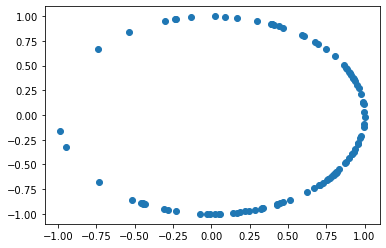

In [ ]:
#exports
import random
import numpy as np
def generate_imbalanced_circle(
    n_points:int=100, n_total:int=10000, 
    weight:float=1.2
) -> np.ndarray:
    '''
    Arugments:
    ----------
        n_points (int): number of points to sample from unit circle. Defaults to `100`.

        n_total (int): number of points to generate uniformly on the unit circle. Defaults ot `10000`.
        
        weight (float): weight modifier for how much to emphasize the x coordinate on the unit circle.
            Defaults to `1.2`. Setting this to `1` results in almost no points on the lefthand side of 
            the circle. Setting it to `2` results in a more uniform balance.

    Returns:
    ----------
        points (np.ndarray): 2 X `n_points` array of the points on the unit circle.
    '''
    theta = np.concatenate((np.linspace(-np.pi, np.pi, n_total), ))
    a, b = 1 * np.cos(theta), 1 * np.sin(theta)
    coords = np.vstack((a, b)).T
    pnts = coords[
        random.choices(
            np.arange(0, coords.shape[0]), 
            weights=weight+coords[:, 0].reshape(-1), 
            k=n_points)
    ]
    return pnts

pnts = generate_imbalanced_circle()
plt.scatter(pnts[:, 0], pnts[:, 1])

In [ ]:
pnts = pd.read_csv(os.path.join(os.path.abspath(''), 'data', 'points.csv'))

In [ ]:
Y, out_labels, d_hat, s_hat, sigma, noise, npts, random_points, mgc_kernel, mgc_diffusion_operator = sugar(
    pnts, 
    labels=[],
    noise_cov='knn',
    noise_k=2,
    sparsity_idx=[],
    degree_sigma='std',
    degree_k=10,
    degree_a=2,
    degree_fac=1,
    M=0,
    equalize=False,
    mgc_t=1,
    mgc_sigma='knn',
    mgc_k=10,
    mgc_a=2,
    mgc_fac=1,
    magic_rescale=1,
    suppress=False,
    logger=logger
)

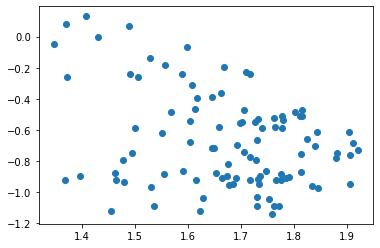

In [ ]:
plt.scatter(Y[:, 0], Y[:, 1])

In [ ]:
sugar(
    data1, 
    labels=[],
    noise_cov='knn',
    noise_k=5,
    sparsity_idx=[],
    degree_sigma='std',
    degree_k=5,
    degree_a=2,
    degree_fac=1,
    M=0,
    equalize=False,
    mgc_t=1,
    mgc_sigma='knn',
    mgc_k=5,
    mgc_a=2,
    mgc_fac=1,
    magic_rescale=1,
    suppress=False,
    logger=logger
)

(array([[ 2.81244708,  4.97545187,  5.46951769,  5.22013447,  7.38313928],
        [13.02672673, 15.19989926, 18.01348903, 17.98527946, 20.15845202],
        [15.76105145, 17.74560565, 20.67018685, 21.54165199, 23.52620622],
        [16.97004647, 18.82984489, 21.68173858, 22.97411777, 24.83391621],
        [17.20868415, 19.03669175, 21.85251808, 23.22709278, 25.0551004 ]]),
 [],
 array([1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1.]),
 'knn',
 array([[[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , -2.25],
         [ 0.75,  1.  ,  2.5 , -1.  , -0.75],
         [-2.25, -2.5 , -1.  ,  2.5 ,  2.25],
         [-2.5 , -2.25, -0.75,  2.25,  2.5 ]],
 
        [[ 2.5 ,  2.25,  0.75, -2.25, -2.5 ],
         [ 2.25,  2.5 ,  1.  , -2.5 , 